           Model       MAE      RMSE        R2
0  Decision Tree  0.084977  0.120797  0.248559
1  Random Forest  0.046626  0.075963  0.702846
2        XGBoost  0.084134  0.115037  0.318512
3            SVR  0.111723  0.139736 -0.005535


<Figure size 1200x600 with 0 Axes>

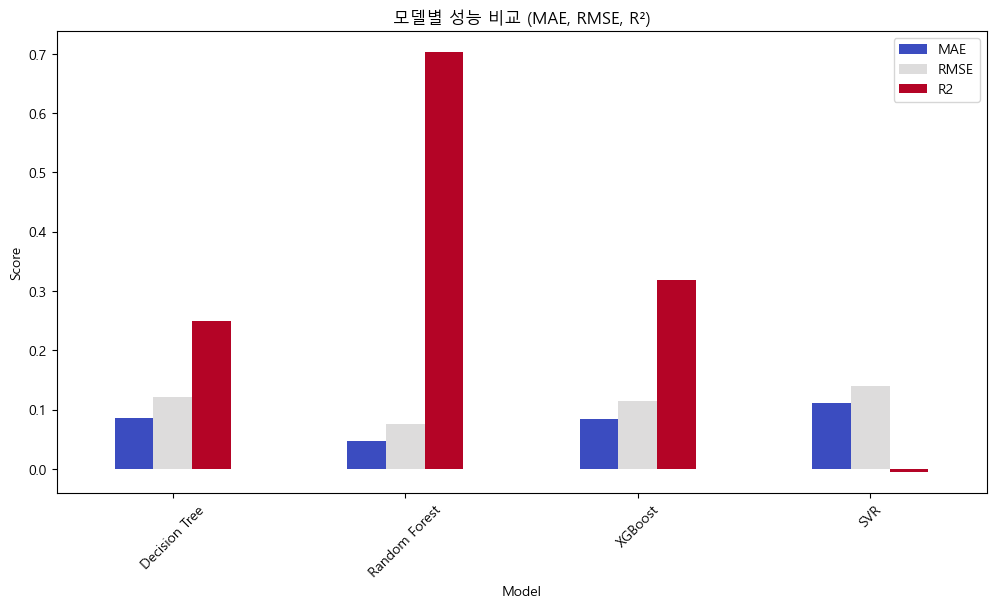

In [29]:
#음주운전 발생 가능성 예측을 위한 4가지 회귀모델 분석(Decision Tree, Random Forest, XGboost, SVR)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib

# 🔹 한글 폰트 설정 (Windows 예시: 'Malgun Gothic' 사용)
matplotlib.rcParams['font.family'] = 'Malgun Gothic'  # Mac: 'AppleGothic', Linux: 'NanumGothic'

# 🔹 CSV 파일 로드
file_path = "df_drink.csv"  
df = pd.read_csv(file_path)

# 🔹 종속 변수(사고 발생 확률) 생성 (연속 값으로 변환)
df["사고 발생 확률"] = df["사고건수"] / df["사고건수"].max()  # 0~1 사이로 정규화

# 🔹 사용할 컬럼 선택
columns = ["사고요일", "사고시", "시군구", "사고 발생 확률"]
df = df[columns]

# 🔹 카테고리형 변수(Label Encoding)
label_encoders = {}
for column in ["사고요일", "사고시", "시군구"]:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])
    label_encoders[column] = le

# 🔹 입력 변수(X) & 타겟 변수(y) 설정
X = df.drop(columns=["사고 발생 확률"])
y = df["사고 발생 확률"]

# 🔹 훈련 & 테스트 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 🔹 비교할 회귀 모델 정의
models = {
    "Decision Tree": DecisionTreeRegressor(max_depth=5, random_state=42),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "XGBoost": xgb.XGBRegressor(n_estimators=50, max_depth=3, learning_rate=0.1),
    "SVR": SVR(kernel="rbf")
}

# 🔹 모델 학습 및 평가
results = []
for name, model in models.items():
    model.fit(X_train, y_train)  # 학습
    y_pred = model.predict(X_test)  # 예측
    
    # 평가 지표 계산
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    results.append([name, mae, rmse, r2])

# 🔹 성능 비교 테이블 출력
df_results = pd.DataFrame(results, columns=["Model", "MAE", "RMSE", "R2"])
print(df_results)

# 🔹 모델별 성능 시각화 (MAE, RMSE, R²)
plt.figure(figsize=(12, 6))
df_results.set_index("Model").plot(kind="bar", figsize=(12, 6), colormap="coolwarm")
plt.title("모델별 성능 비교 (MAE, RMSE, R²)")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.legend(loc="upper right")
plt.show()

In [ ]:
# 4가지 모델 중 Random Forest Regression모델의 R2이 가장 높고 RMSE, MAE는 가장 낮아 최종모델로 Random Forest Regression를 선정하였다.

In [89]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
import numpy as np

# 데이터 로드
file_path = "df_drink.csv"  
df = pd.read_csv(file_path)

# 사고 발생 확률 예측을 위한 변수 설정 (이진 분류 X, 연속 값 활용)
df['사고 발생 확률'] = df['사고건수'] / df['사고건수'].max()  # 사고 발생 건수를 정규화 (0~1 사이)

# 사용할 열 선택
columns = ['사고요일', '사고시', '시군구', '사고 발생 확률']
df = df[columns]

# 🔹 모든 시간 강제 포함 (00시~23시)
all_hours = [f"{str(i).zfill(2)}시" for i in range(0, 24)]

# 카테고리형 변수 인코딩
label_encoders = {}
for column in ['사고요일', '사고시', '시군구']:
    le = LabelEncoder()
    if column == '사고시':
        le.fit(all_hours)  # 모든 시간 포함
    else:
        le.fit(df[column])
    df[column] = le.transform(df[column])
    label_encoders[column] = le

# 입력(X)과 타겟(Y) 분리
X = df.drop(columns=['사고 발생 확률'])
y = df['사고 발생 확률']

# 학습 및 테스트 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Random Forest 회귀 모델 학습
model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
model.fit(X_train, y_train)

# 예측 함수 정의
def predict_accident_probability(day, hour, district):
    day_encoded = label_encoders['사고요일'].transform([day])[0]
    hour_encoded = label_encoders['사고시'].transform([hour])[0]  # "00시"도 변환 가능
    district_encoded = label_encoders['시군구'].transform([district])[0]

    input_data = pd.DataFrame([[day_encoded, hour_encoded, district_encoded]], 
                              columns=['사고요일', '사고시', '시군구'])
    
    probability = model.predict(input_data)[0]  # 사고 발생 확률 예측
    return probability

# 특정 조건에서 사고 발생 확률 예측
day = '목요일'
hour = '23시'
district = '서울특별시 강남구 청담동'

probability = predict_accident_probability(day, hour, district)
print(f'🚗 {day} {hour} {district}에서 사고 발생 확률: {probability:.2%}')

🚗 목요일 23시 서울특별시 강남구 청담동에서 사고 발생 확률: 83.76%


In [266]:
# 예측 함수 정의
def predict_accident_probability(day, hour, district):
    day_encoded = label_encoders['사고요일'].transform([day])[0]
    hour_encoded = label_encoders['사고시'].transform([hour])[0]  # "00시"도 변환 가능
    district_encoded = label_encoders['시군구'].transform([district])[0]

    input_data = pd.DataFrame([[day_encoded, hour_encoded, district_encoded]], 
                              columns=['사고요일', '사고시', '시군구'])
    
    probability = model.predict(input_data)[0]  # 사고 발생 확률 예측
    return probability

# 특정 조건에서 사고 발생 확률 예측
day = '수요일'
hour = '23시'
district = '서울특별시 종로구 가회동'

probability = predict_accident_probability(day, hour, district)
print(f'🚗 {day} {hour} {district}에서 사고 발생 확률: {probability:.2%}')

🚗 수요일 23시 서울특별시 종로구 가회동에서 사고 발생 확률: 21.35%


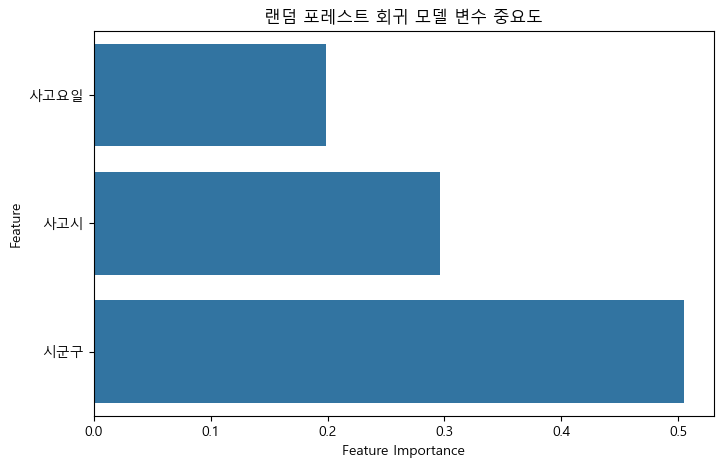

In [41]:
# 변수 중요도 추출
importance = model.feature_importances_

# 시각화
plt.figure(figsize=(8, 5))
sns.barplot(x=importance, y=X.columns)
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("랜덤 포레스트 회귀 모델 변수 중요도")
plt.show()